In [482]:
import pandas as pd
df = pd.read_csv('./dataset/btc-01_2025-09-2025-volume-15min/btc-01_2025-09-2025-volume-15min.csv')

In [483]:
df.shape

(19686, 10)

In [484]:
df.head()

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2025-01-01 00:32:32.519130+00:00,46273,93576.00,93940.00,93489.03,93940.00,290.05130,128.99844,46273,2.717276e+07
1,2025-01-01 00:57:57.067039+00:00,82520,93940.00,94330.59,93836.61,94320.00,290.12551,208.66780,36247,2.729984e+07
2,2025-01-01 01:05:28.341289+00:00,109125,94320.00,94509.42,93997.86,94000.00,292.83859,156.24683,26605,2.760956e+07
3,2025-01-01 01:31:56.527742+00:00,143810,94000.00,94172.00,93819.60,93947.67,292.12049,130.53835,34685,2.744654e+07
4,2025-01-01 02:16:23.680412+00:00,195758,93947.67,93978.18,93578.77,93753.02,290.00191,144.23861,51948,2.719289e+07


In [485]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19686 entries, 0 to 19685
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date_time         19686 non-null  object 
 1   tick_num          19686 non-null  int64  
 2   open              19686 non-null  float64
 3   high              19686 non-null  float64
 4   low               19686 non-null  float64
 5   close             19686 non-null  float64
 6   volume            19686 non-null  float64
 7   cum_buy_volume    19686 non-null  float64
 8   cum_ticks         19686 non-null  int64  
 9   cum_dollar_value  19686 non-null  float64
dtypes: float64(7), int64(2), object(1)
memory usage: 1.5+ MB


In [486]:
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.set_index('date_time')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19686 entries, 2025-01-01 00:32:32.519130+00:00 to 2025-09-30 23:12:57.728052+00:00
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tick_num          19686 non-null  int64  
 1   open              19686 non-null  float64
 2   high              19686 non-null  float64
 3   low               19686 non-null  float64
 4   close             19686 non-null  float64
 5   volume            19686 non-null  float64
 6   cum_buy_volume    19686 non-null  float64
 7   cum_ticks         19686 non-null  int64  
 8   cum_dollar_value  19686 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.5 MB


In [487]:
df.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2025-01-01 00:32:32.519130+00:00,46273,93576.00,93940.00,93489.03,93940.00,290.05130,128.99844,46273,2.717276e+07
2025-01-01 00:57:57.067039+00:00,82520,93940.00,94330.59,93836.61,94320.00,290.12551,208.66780,36247,2.729984e+07
2025-01-01 01:05:28.341289+00:00,109125,94320.00,94509.42,93997.86,94000.00,292.83859,156.24683,26605,2.760956e+07
2025-01-01 01:31:56.527742+00:00,143810,94000.00,94172.00,93819.60,93947.67,292.12049,130.53835,34685,2.744654e+07
2025-01-01 02:16:23.680412+00:00,195758,93947.67,93978.18,93578.77,93753.02,290.00191,144.23861,51948,2.719289e+07


## Aplly symmetric CUSUM filter where the threshold is the standard deviation of daily returns

In [488]:
import numpy as np
daily = df['close'].resample('1D').last().to_frame()
daily['returns'] = np.log(daily['close'] / daily['close'].shift(1))
daily.dropna(inplace=True)

In [489]:
daily.head()

,close,returns
date_time,,
2025-01-02 00:00:00+00:00,97005.19,0.024521
2025-01-03 00:00:00+00:00,98119.37,0.011420
2025-01-04 00:00:00+00:00,98220.50,0.001030
2025-01-05 00:00:00+00:00,98644.01,0.004303
2025-01-06 00:00:00+00:00,101998.16,0.033437


In [490]:
std_daily_ret = daily['returns'].std()
std_daily_ret

0.021981948882745583

In [491]:
from mlfinpy.filters import cusum_filter
cusum_events = cusum_filter(df['close'], threshold = std_daily_ret)

In [492]:
len(cusum_events)

445

In [493]:
from mlfinpy.labeling.labeling import add_vertical_barrier

verticle_barriers = add_vertical_barrier(cusum_events, df['close'],num_days=1)

In [494]:
verticle_barriers.head()

2025-01-02 00:46:36.027416+00:00   2025-01-03 01:17:25.035333+00:00
2025-01-02 12:20:05.415519+00:00   2025-01-03 13:02:37.110693+00:00
2025-01-03 16:25:56.727509+00:00   2025-01-04 16:34:45.459982+00:00
2025-01-06 05:40:00.846638+00:00   2025-01-07 05:42:46.034939+00:00
2025-01-06 14:54:09.659062+00:00   2025-01-07 14:56:34.063398+00:00
Name: date_time, dtype: datetime64[ns, UTC]

In [495]:
from mlfinpy.labeling.labeling import get_events, drop_labels
from mlfinpy.util import get_daily_vol
from mlfinpy.labeling import get_events

pt_sl = [1, 1]
min_ret = 0.005
daily_vol = get_daily_vol(close=df['close'], lookback=50)
triple_barrier_events = get_events(close=df['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=verticle_barriers,
                                               side_prediction=None)

2025-10-19 01:45:44.060461 100.0% triple_barriers done after 0.02 minutes. Remaining 0.0 minutes..


In [496]:
triple_barrier_events

,t1,trgt,pt,sl
2025-01-02 12:20:05.415519+00:00,2025-01-03 13:02:37.110693+00:00,0.009694,1,1
2025-01-03 16:25:56.727509+00:00,2025-01-04 16:34:45.459982+00:00,0.011632,1,1
2025-01-06 05:40:00.846638+00:00,2025-01-06 08:51:49.910793+00:00,0.006006,1,1
2025-01-06 14:54:09.659062+00:00,2025-01-06 15:53:36.356980+00:00,0.010038,1,1
2025-01-07 14:37:09.217248+00:00,2025-01-07 15:07:50.195220+00:00,0.010228,1,1
...,...,...,...,...
2025-09-22 06:00:16.600500+00:00,2025-09-22 06:02:06.873261+00:00,0.006751,1,1
2025-09-25 12:30:00.083393+00:00,2025-09-25 17:20:34.660156+00:00,0.008702,1,1
2025-09-25 17:50:27.578371+00:00,2025-09-26 17:51:27.215809+00:00,0.013774,1,1
2025-09-28 22:10:24.601186+00:00,2025-09-29 13:43:12.088604+00:00,0.011553,1,1


In [497]:
from mlfinpy.labeling import get_bins
meta_labels = get_bins(triple_barrier_events, df['close'])

In [498]:
clean_meta_labels = drop_labels(meta_labels, min_pct=0.1)

dropped label:  0 0.08181818181818182


In [499]:
meta_labels.bin.value_counts()

bin
 1    205
-1    199
 0     36
Name: count, dtype: int64

In [500]:
clean_meta_labels.bin.value_counts()

bin
 1    205
-1    199
Name: count, dtype: int64

In [501]:
clean_meta_labels

,ret,trgt,bin
2025-01-06 05:40:00.846638+00:00,-0.006516,0.006006,-1
2025-01-06 14:54:09.659062+00:00,0.013930,0.010038,1
2025-01-07 14:37:09.217248+00:00,-0.013160,0.010228,-1
2025-01-07 15:34:07.286287+00:00,-0.025968,0.024445,-1
2025-01-08 06:33:08.351718+00:00,-0.013903,0.012384,-1
...,...,...,...
2025-09-17 06:05:41.713556+00:00,-0.007480,0.007196,-1
2025-09-18 03:15:37.879647+00:00,-0.007497,0.007320,-1
2025-09-22 06:00:16.600500+00:00,-0.007499,0.006751,-1
2025-09-25 12:30:00.083393+00:00,-0.009687,0.008702,-1


In [502]:
first_model_data = pd.concat([df,clean_meta_labels],axis=1).dropna()

In [503]:
first_model_data = first_model_data.sort_index()
# first_model_data = first_model_data.drop(['ret'],axis=1)
# first_model_data = first_model_data.drop(['trgt'],axis=1)
first_model_data.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value,ret,trgt,bin
2025-01-06 05:40:00.846638+00:00,12071294,99532.47,99826.36,99532.46,99726.77,290.35685,179.67072,38703,2.895273e+07,-0.006516,0.006006,-1.0
2025-01-06 14:54:09.659062+00:00,13444322,100729.89,101000.00,100637.31,101000.00,290.03452,185.60305,31685,2.925004e+07,0.013930,0.010038,1.0
2025-01-07 14:37:09.217248+00:00,16321709,100668.01,100668.02,100207.76,100211.00,290.07701,88.04853,37363,2.912670e+07,-0.013160,0.010228,-1.0
2025-01-07 15:34:07.286287+00:00,16980017,98538.99,98546.55,98250.00,98307.50,290.02242,129.14338,27972,2.853156e+07,-0.025968,0.024445,-1.0
2025-01-08 06:33:08.351718+00:00,20355442,96187.64,96194.76,95692.00,95754.63,290.00107,72.05013,24678,2.782366e+07,-0.013903,0.012384,-1.0


In [504]:
split_idx = int(len(first_model_data) * 0.8)

In [505]:
first_model_data = first_model_data.sort_index()

split_idx = int(len(first_model_data) * 0.8)

train = first_model_data.iloc[:split_idx].copy()
test  = first_model_data.iloc[split_idx:].copy()

print(f"Train interval: {train.index.min()} → {train.index.max()}")
print(f"Test  interval: {test.index.min()}  → {test.index.max()}")

Train interval: 2025-01-06 05:40:00.846638+00:00 → 2025-05-25 08:50:40.882855+00:00
Test  interval: 2025-05-25 23:00:12.625691+00:00  → 2025-09-28 22:10:24.601186+00:00


In [506]:
features = [
    'open', 'high', 'low', 'close', 'volume',
    'cum_buy_volume', 'cum_ticks', 'cum_dollar_value', 'trgt',
]

X_train, y_train = train[features], train['bin']
X_test, y_test = test[features], test['bin']

In [507]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    class_weight='balanced',  
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# evaluare
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[42  4]
 [25 10]]
              precision    recall  f1-score   support

        -1.0      0.627     0.913     0.743        46
         1.0      0.714     0.286     0.408        35

    accuracy                          0.642        81
   macro avg      0.671     0.599     0.576        81
weighted avg      0.665     0.642     0.599        81



In [508]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

AUC Score: 0.581


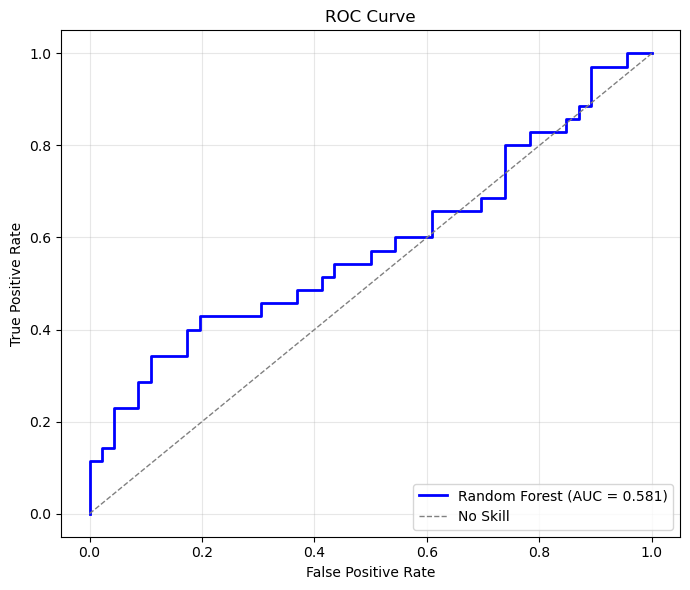

In [509]:
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
print(f"AUC Score: {roc_auc:.3f}")

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [510]:
first_model_data['ret_1'] = first_model_data['close'].pct_change(1)
first_model_data['ret_5'] = first_model_data['close'].pct_change(5)

first_model_data['ma_fast'] = first_model_data['close'].rolling(10).mean()
first_model_data['ma_slow'] = first_model_data['close'].rolling(50).mean()
first_model_data['ma_ratio'] = first_model_data['ma_fast'] / first_model_data['ma_slow'] - 1

first_model_data['vol_chg'] = first_model_data['volume'].pct_change(1)
first_model_data['hl_spread'] = (first_model_data['high'] - first_model_data['low']) / first_model_data['close']



ema_12 = first_model_data['close'].ewm(span=12, adjust=False).mean()
ema_26 = first_model_data['close'].ewm(span=26, adjust=False).mean()
first_model_data['macd'] = ema_12 - ema_26
first_model_data['macd_signal'] = first_model_data['macd'].ewm(span=9, adjust=False).mean()
first_model_data['macd_hist'] = first_model_data['macd'] - first_model_data['macd_signal']

delta = first_model_data['close'].diff()
gain = delta.clip(lower=0)
loss = (-delta).clip(lower=0)
avg_gain = gain.rolling(14, min_periods=14).mean()
avg_loss = loss.rolling(14, min_periods=14).mean()
rs = avg_gain / avg_loss.replace(0, np.nan)
first_model_data['rsi'] = 100 - (100 / (1 + rs))


first_model_data['trend_strength'] = (first_model_data['ma_fast'] - first_model_data['ma_slow']) / first_model_data['ma_slow']
first_model_data['price_above_ma'] = (first_model_data['close'] > first_model_data['ma_slow']).astype(int)

first_model_data = first_model_data.dropna()


split_idx = int(len(first_model_data) * 0.8)
train = first_model_data.iloc[:split_idx]
test  = first_model_data.iloc[split_idx:]

features = [
    'open','high','low','close','volume',
    'cum_buy_volume','cum_ticks','cum_dollar_value',
    'ret_1','ret_5','ma_ratio','vol_chg','hl_spread',
    'macd','macd_signal','macd_hist',
    'rsi','trend_strength','price_above_ma','trgt'
]

X_train, y_train = train[features], train['bin']
X_test,  y_test  = test[features],  test['bin']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np

rf_features = RandomForestClassifier(
    bootstrap=True,
    class_weight='balanced',
    max_depth=4,
    max_features=0.5,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    n_jobs=-1,
    random_state=42
)

rf_features.fit(X_train, y_train)


y_proba_test = rf_features.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred = np.where(y_proba_test > threshold, 1, -1)


print(confusion_matrix(y_test, y_pred, labels=[-1, 1]))
print(classification_report(y_test, y_pred, labels=[-1, 1],
                            target_names=['neg (-1)', 'pos (1)'], digits=3))

y_proba_train = rf_features.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_proba_train)
test_auc  = roc_auc_score(y_test,  y_proba_test)

print(f"AUC (train): {train_auc:.3f}")
print(f"AUC (test):  {test_auc:.3f}")

[[12 27]
 [ 2 30]]
              precision    recall  f1-score   support

    neg (-1)      0.857     0.308     0.453        39
     pos (1)      0.526     0.938     0.674        32

    accuracy                          0.592        71
   macro avg      0.692     0.623     0.563        71
weighted avg      0.708     0.592     0.553        71

AUC (train): 0.979
AUC (test):  0.705


AUC Score: 0.660


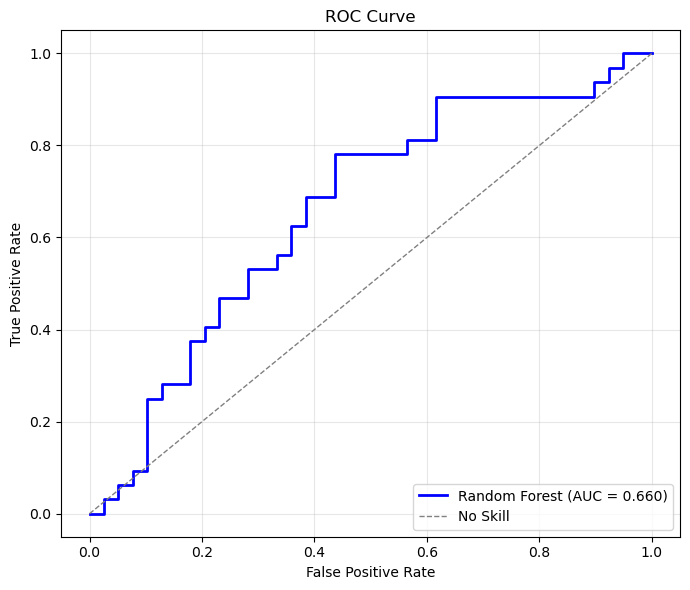

In [534]:
y_prob = rf_features.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
print(f"AUC Score: {roc_auc:.3f}")

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[[25 14]
 [14 18]]
              precision    recall  f1-score   support

        -1.0      0.641     0.641     0.641        39
         1.0      0.562     0.562     0.562        32

    accuracy                          0.606        71
   macro avg      0.602     0.602     0.602        71
weighted avg      0.606     0.606     0.606        71

AUC Score: 0.624


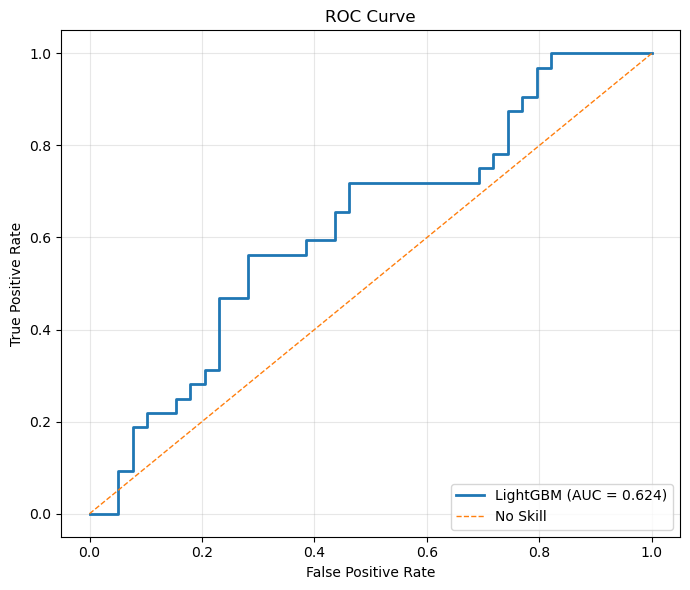

In [513]:
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


y_train_bin = (y_train == 1).astype(int)
y_test_bin  = (y_test  == 1).astype(int)


lgbm = LGBMClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)


lgbm.fit(X_train, y_train_bin)


y_proba = lgbm.predict_proba(X_test)[:, 1]
threshold = 0.4

y_pred = np.where(y_proba > threshold, 1, -1)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


fpr, tpr, thresholds = roc_curve(y_test_bin, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
print(f"AUC Score: {roc_auc:.3f}")


plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, lw=2, label=f'LightGBM (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [514]:
X_train.shape

(284, 20)

In [375]:
X_test.shape

(507, 20)